In [15]:
%reset -f
import os
import sys
import copy
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [16]:
# size of LSTM hidden state
lstm_hidden_size = 10 # default = 24
# Optimizer learning rate
learning_rate = 0.02
# Epoch
training_epochs = 150

def standarize(x):
    M = np.max(x)
    m = np.min(x)
    return M,m,2*(x-m)/(M-m)-1

def un_standarize(x, M, m):
    return (x+1)*(M-m)/2+m

def cal_acc(p, a):
    
    error = np.sum(abs(a-p))/np.sum(abs(a))
    acc = 1-error
    return acc

In [17]:
# parameters for Kalman filter
G = np.array([[1]])
F = np.array([[1]])
W = np.array([[0.1]]) # 恣意的に与える必要がある
V = np.array([[10]]) # 上に同じ

def kalman_filter(m, C, y, G=G, F=F, W=W, V=V):
    """
    Kalman Filter
    m: 時点t-1のフィルタリング分布の平均
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    """
    a = G @ m
    R = G @ C @ G.T + W
    f = F @ a
    Q = F @ R @ F.T + V
    # 逆行列と何かの積を取る場合は、invよりsolveを使った方がいいらしい
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    # K = R @ F.T @ np.linalg.inv(Q)
    m = a + K @ (y - f)
    C = R - K @ F @ R
    return m, C

def kalman_smoothing(s, S, m, C, G=G, W=W):
    """
    Kalman smoothing
    """
    # 1時点先予測分布のパラメータ計算
    a = G @ m
    R = G @ C @ G.T + W
    # 平滑化利得の計算
    # solveを使った方が約30%速くなる
    A = np.linalg.solve(R.T, G @ C.T).T
    # A = C @ G.T @ np.linalg.inv(R)
    # 状態の更新
    s = m + A @ (s - a)
    S = C + A @ (S - R) @ A.T
    return s, S

def apply_Kalman(src_data, m0, C0):
    # length of data
    T = len(src_data)
    
    # for results
    m = np.zeros((T, 1))
    C = np.zeros((T, 1, 1))
    s = np.zeros((T, 1))
    S = np.zeros((T, 1))

    # Kalman filter
    for t in range(T):
        if t == 0:
            m[t], C[t] = kalman_filter(m0, C0, src_data[t])
        else:
            m[t], C[t] = kalman_filter(m[t-1], C[t-1], src_data[t])

    # Kalman smoothing
    for t in range(T):
        t = T - t - 1
        if t == T - 1:
            s[t] = m[t]
            S[t] = C[t]
        else:
            s[t], S[t] = kalman_smoothing(s[t+1], S[t+1], m[t], C[t])
    return s

In [116]:
date = 'data/02_16/union/'
action = 'shinten'

# initial state for kalman filter
m0 = np.array([[0]])
C0 = np.array([[1e7]])

n_trials = 40

frc = []
emg = []
zero_str = ''

for n in range(n_trials):
    if n < 9:
        zero_str = '0'
    else:
        zero_str = ''
    path = '/home/tachibana/Downloads/' + date + action + '/force/force_' + zero_str + str(n+1) + '.csv'
    d = np.loadtxt(path, delimiter=',', dtype=float)
    s = apply_Kalman(d[0, :], m0, C0) # data_x
    ss = apply_Kalman(d[1, :], m0, C0) # data_y
    content = np.concatenate([s,ss],1).transpose()
    frc.append(content)

for n in range(n_trials):
    if n < 9:
        zero_str = '0'
    else:
        zero_str = ''
    path = '/home/tachibana/Downloads/' + date + action + '/emg/emg_'+ zero_str + str(n+1) +'.csv'
    d = np.loadtxt(path, delimiter=',', dtype=float)
    emg.append(d)
emg_size, T = emg[0].shape
frc_size = frc[0].shape[0]
M_emg, m_emg, emg_norm = standarize(emg)
M_frc, m_frc, frc_norm = standarize(frc)

# concat emg and force
trials = np.array([np.concatenate([emg_norm[n], frc_norm[n]], 0).transpose() for n in range(n_trials)])

In [117]:
n_of_input_samples = 100
forward_estimation = 56

inputs = np.array([[trials[n][t:t + 100, :] for t in range(T - n_of_input_samples - forward_estimation)] for n in range(n_trials)])
outputs = np.array([trials[n][n_of_input_samples + forward_estimation:, emg_size:] for n in range(n_trials)])

# make train/test/val data
# 0-7: train, 8:val, 9:test
# 0-31: train, 32~35:val, 36~40:test
# train:val:test = 8:1:1

data_set = 40
order = np.array(range(data_set))
ind_1 = 32
ind_2 = 36

x_train = torch.from_numpy(np.concatenate(inputs[order[0:ind_1]], axis=0).astype(np.float32)).clone()
x_val = torch.from_numpy(np.concatenate(inputs[order[ind_1:ind_2]],axis=0).astype(np.float32)).clone()
x_test = torch.from_numpy(np.concatenate(inputs[order[ind_2:]],axis=0).astype(np.float32)).clone()

y_train = torch.from_numpy(np.concatenate(outputs[order[0:ind_1]], axis=0).astype(np.float32)).clone()
y_val = torch.from_numpy(np.concatenate(outputs[order[ind_1:ind_2]], axis=0).astype(np.float32)).clone()
y_test = torch.from_numpy(np.concatenate(outputs[order[ind_2:]], axis=0).astype(np.float32)).clone()

print(y_train.shape)
"""
order = np.array([0,1,2,3,4,5,6,7,8,9]) # the last set is test data, the second last is validation data

x_train = torch.from_numpy(np.concatenate(inputs[order[0:n_trials-2]], axis=0).astype(np.float32))
x_val = torch.from_numpy(inputs[order[n_trials-2]].astype(np.float32))
x_test = torch.from_numpy(inputs[order[n_trials-1]].astype(np.float32))

y_train = torch.from_numpy(np.concatenate(outputs[order[0:n_trials-2]], axis=0).astype(np.float32))
y_val = torch.from_numpy(outputs[order[n_trials-2]].astype(np.float32))
y_test = outputs[order[n_trials-1]].astype(np.float32)

print(x_train.shape)
"""

torch.Size([27008, 2])


'\norder = np.array([0,1,2,3,4,5,6,7,8,9]) # the last set is test data, the second last is validation data\n\nx_train = torch.from_numpy(np.concatenate(inputs[order[0:n_trials-2]], axis=0).astype(np.float32))\nx_val = torch.from_numpy(inputs[order[n_trials-2]].astype(np.float32))\nx_test = torch.from_numpy(inputs[order[n_trials-1]].astype(np.float32))\n\ny_train = torch.from_numpy(np.concatenate(outputs[order[0:n_trials-2]], axis=0).astype(np.float32))\ny_val = torch.from_numpy(outputs[order[n_trials-2]].astype(np.float32))\ny_test = outputs[order[n_trials-1]].astype(np.float32)\n\nprint(x_train.shape)\n'

In [118]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, in_size = 2+2, out_size = 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = in_size, hidden_size = hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)
        #self.fc = nn.Linear(10, out_size)

    def forward(self, x, h = None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, h
    
def err_calc(input1,input2):
    num_abs = np.abs(input1-input2)
    numerator = np.sum(num_abs)
    den_abs = np.abs(input1)
    denominator = np.sum(den_abs)
    err_perc = (numerator/denominator)*100

    return err_perc

def show_graph(col_matrix1,col_matrix2,size1,size2):
    #col_matrix1 = col_matrix1[100:120,:]
    #col_matrix2 = col_matrix2[100:120,:]
    fig, ax = plt.subplots()
    #ax.figure(figsize=(size1,size2))
    #ax.title("LSTM estimation result (extention)")
    #ax = fig.add_subplot(3,4,time+1)
    ax.set_title('Estimation result using LSTM',size = 20)
    #ax.set_title('LSTM estimation result (flextion)',size = 15)
    ax.set_xlabel('Time step',size = size1)
    ax.set_ylabel('Force [N]',size = size2)
    ax.plot(col_matrix1[:,0],'r',linestyle='-',label = 'true Fx')
    ax.plot(col_matrix1[:,1],'b',linestyle='-',label = 'true Fy')
    ax.plot(col_matrix2[:,0],'r',linestyle='--',label = 'predicted Fx')
    ax.plot(col_matrix2[:,1],'b',linestyle='--',label = 'predicted Fy')

    ax.legend(fontsize = 10)
    save_name = action + '_' + str(forward_estimation+1) + '_' + str(time)
    plt.savefig(save_name) 
    plt.show()
    return

epoch 0: train - 0.0893, val: - 0.1115
epoch 10: train - 0.0182, val: - 0.0595
epoch 20: train - 0.0089, val: - 0.0313
epoch 30: train - 0.0078, val: - 0.0261
epoch 40: train - 0.0066, val: - 0.025
epoch 50: train - 0.0061, val: - 0.0248
epoch 60: train - 0.0056, val: - 0.0241
epoch 70: train - 0.0052, val: - 0.0244
epoch 80: train - 0.0049, val: - 0.0247
epoch 90: train - 0.0047, val: - 0.0239
epoch 100: train - 0.0046, val: - 0.0232
epoch 110: train - 0.0044, val: - 0.0228
epoch 120: train - 0.0042, val: - 0.0225
epoch 130: train - 0.0045, val: - 0.0223
epoch 140: train - 0.0039, val: - 0.0208


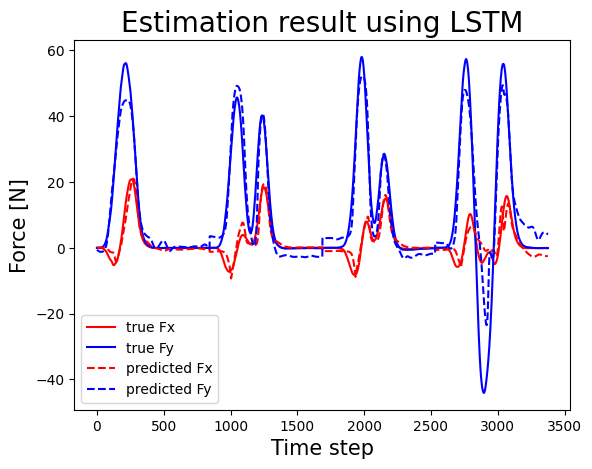

0
0.6733106773709243
epoch 0: train - 0.1104, val: - 0.1243
epoch 10: train - 0.0294, val: - 0.0711
epoch 20: train - 0.0158, val: - 0.0508
epoch 30: train - 0.0087, val: - 0.0282
epoch 40: train - 0.0072, val: - 0.0208
epoch 50: train - 0.0065, val: - 0.0249
epoch 60: train - 0.0061, val: - 0.0237
epoch 70: train - 0.0058, val: - 0.0236
epoch 80: train - 0.0055, val: - 0.0237
epoch 90: train - 0.0051, val: - 0.0235
epoch 100: train - 0.0048, val: - 0.0231
epoch 110: train - 0.0045, val: - 0.0225
epoch 120: train - 0.0043, val: - 0.0229
epoch 130: train - 0.0041, val: - 0.022
epoch 140: train - 0.004, val: - 0.0219


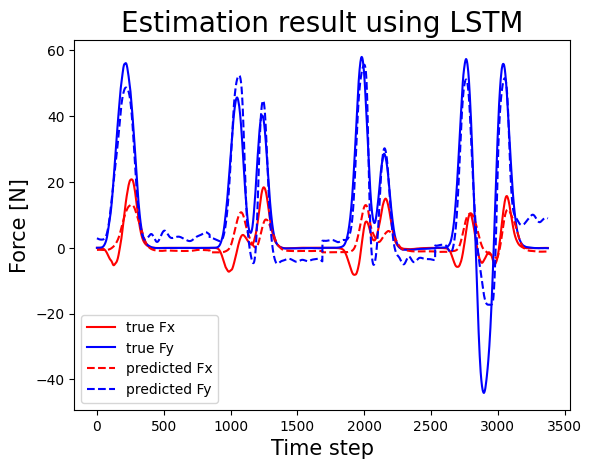

1
0.5262445557599148
epoch 0: train - 0.0974, val: - 0.1188
epoch 10: train - 0.0161, val: - 0.0526
epoch 20: train - 0.0092, val: - 0.0259
epoch 30: train - 0.0079, val: - 0.0223
epoch 40: train - 0.0072, val: - 0.0252
epoch 50: train - 0.0068, val: - 0.0248
epoch 60: train - 0.0064, val: - 0.023
epoch 70: train - 0.0062, val: - 0.0238
epoch 80: train - 0.006, val: - 0.0239
epoch 90: train - 0.0057, val: - 0.0234
epoch 100: train - 0.0055, val: - 0.0231
epoch 110: train - 0.0053, val: - 0.0224
epoch 120: train - 0.0051, val: - 0.022
epoch 130: train - 0.0049, val: - 0.028
epoch 140: train - 0.0047, val: - 0.0336


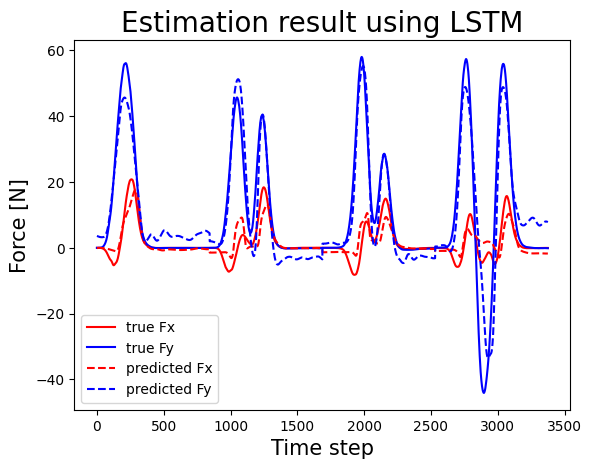

2
0.5784975985072589
epoch 0: train - 0.1397, val: - 0.1374
epoch 10: train - 0.0195, val: - 0.0514
epoch 20: train - 0.0115, val: - 0.0345
epoch 30: train - 0.0089, val: - 0.0256
epoch 40: train - 0.0079, val: - 0.0242
epoch 50: train - 0.0073, val: - 0.0256
epoch 60: train - 0.0068, val: - 0.0243
epoch 70: train - 0.0065, val: - 0.0236
epoch 80: train - 0.0063, val: - 0.0242
epoch 90: train - 0.006, val: - 0.0239
epoch 100: train - 0.0057, val: - 0.0237
epoch 110: train - 0.0054, val: - 0.0236
epoch 120: train - 0.0053, val: - 0.023
epoch 130: train - 0.0052, val: - 0.0227
epoch 140: train - 0.0051, val: - 0.0224


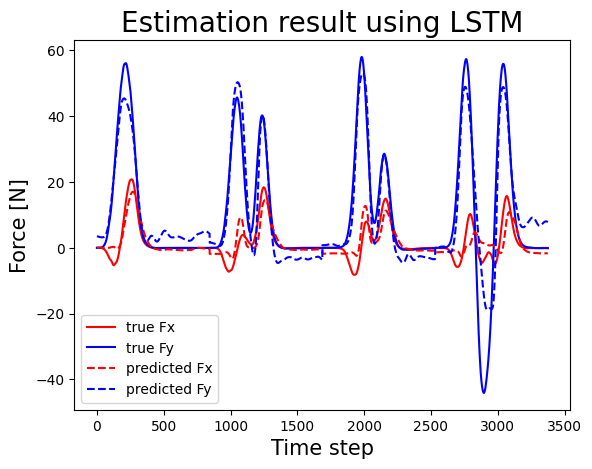

3
0.5743363754422395
epoch 0: train - 0.0961, val: - 0.0964
epoch 10: train - 0.0208, val: - 0.0654
epoch 20: train - 0.0122, val: - 0.0382
epoch 30: train - 0.0092, val: - 0.026
epoch 40: train - 0.0076, val: - 0.0258
epoch 50: train - 0.0068, val: - 0.0259
epoch 60: train - 0.0063, val: - 0.0238
epoch 70: train - 0.0059, val: - 0.0236
epoch 80: train - 0.0056, val: - 0.0237
epoch 90: train - 0.0053, val: - 0.023
epoch 100: train - 0.0051, val: - 0.023
epoch 110: train - 0.0049, val: - 0.0228
epoch 120: train - 0.0048, val: - 0.0223
epoch 130: train - 0.0046, val: - 0.0217
epoch 140: train - 0.0045, val: - 0.021


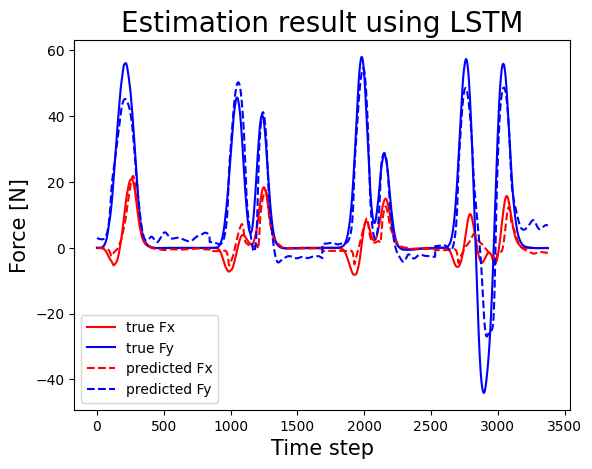

4
0.6295370194711127
epoch 0: train - 0.0896, val: - 0.1131
epoch 10: train - 0.0258, val: - 0.0582
epoch 20: train - 0.012, val: - 0.0359
epoch 30: train - 0.009, val: - 0.0249
epoch 40: train - 0.0073, val: - 0.0268
epoch 50: train - 0.0065, val: - 0.0252
epoch 60: train - 0.0061, val: - 0.025
epoch 70: train - 0.0057, val: - 0.0248
epoch 80: train - 0.0052, val: - 0.0241
epoch 90: train - 0.0049, val: - 0.0236
epoch 100: train - 0.0046, val: - 0.0226
epoch 110: train - 0.0044, val: - 0.0216
epoch 120: train - 0.0042, val: - 0.0206
epoch 130: train - 0.004, val: - 0.0201
epoch 140: train - 0.0039, val: - 0.0197


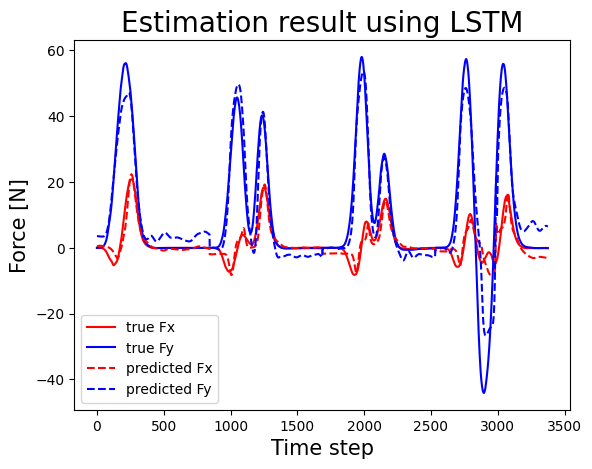

5
0.6483334909322533
epoch 0: train - 0.1003, val: - 0.1151
epoch 10: train - 0.0159, val: - 0.0518
epoch 20: train - 0.0099, val: - 0.0304
epoch 30: train - 0.0075, val: - 0.0235
epoch 40: train - 0.0067, val: - 0.0245
epoch 50: train - 0.0064, val: - 0.0234
epoch 60: train - 0.0061, val: - 0.0236
epoch 70: train - 0.0059, val: - 0.0224
epoch 80: train - 0.0057, val: - 0.0224
epoch 90: train - 0.0054, val: - 0.0219
epoch 100: train - 0.0052, val: - 0.0216
epoch 110: train - 0.0049, val: - 0.0208
epoch 120: train - 0.0047, val: - 0.0203
epoch 130: train - 0.0047, val: - 0.0193
epoch 140: train - 0.0044, val: - 0.0192


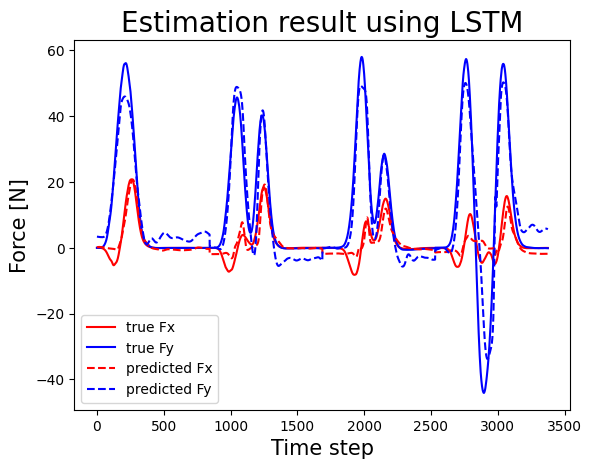

6
0.6194261150940275
epoch 0: train - 0.0629, val: - 0.0907
epoch 10: train - 0.0131, val: - 0.043
epoch 20: train - 0.009, val: - 0.0271
epoch 30: train - 0.0081, val: - 0.0242
epoch 40: train - 0.0065, val: - 0.0243
epoch 50: train - 0.0059, val: - 0.0256
epoch 60: train - 0.0054, val: - 0.0239
epoch 70: train - 0.0051, val: - 0.0237
epoch 80: train - 0.0049, val: - 0.0231
epoch 90: train - 0.0046, val: - 0.0208
epoch 100: train - 0.0044, val: - 0.019
epoch 110: train - 0.0042, val: - 0.018
epoch 120: train - 0.0041, val: - 0.0175
epoch 130: train - 0.0039, val: - 0.0171
epoch 140: train - 0.0037, val: - 0.0171


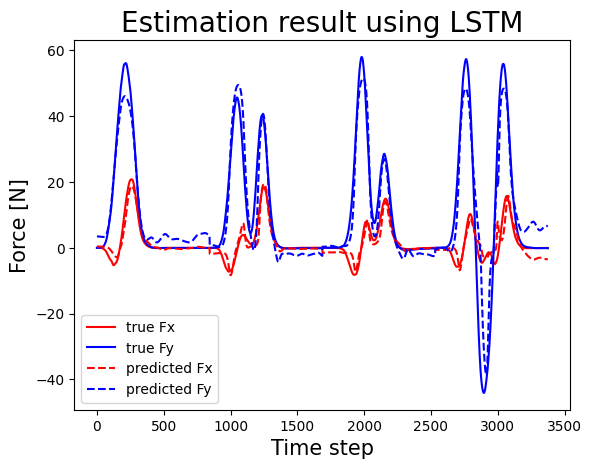

7
0.6673513439039915
epoch 0: train - 0.1236, val: - 0.1407
epoch 10: train - 0.0373, val: - 0.0783
epoch 20: train - 0.0154, val: - 0.0455
epoch 30: train - 0.0094, val: - 0.0297
epoch 40: train - 0.008, val: - 0.0234
epoch 50: train - 0.007, val: - 0.0231
epoch 60: train - 0.0063, val: - 0.0242
epoch 70: train - 0.0056, val: - 0.0243
epoch 80: train - 0.0052, val: - 0.0246
epoch 90: train - 0.0051, val: - 0.0246
epoch 100: train - 0.0049, val: - 0.0237
epoch 110: train - 0.0048, val: - 0.023
epoch 120: train - 0.0048, val: - 0.0228
epoch 130: train - 0.0047, val: - 0.0223
epoch 140: train - 0.0046, val: - 0.022


KeyboardInterrupt: 

In [119]:
acc_sum = 0.0
times = 20
minus_time = 0
acc_l = []
from sklearn.metrics import accuracy_score, confusion_matrix

for time in range(times):

    # Initializing the model
    model = LSTM(hidden_size = lstm_hidden_size)
    model.train()

    # Training
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    mse_loss = torch.nn.MSELoss()

    best_model = None
    min_val_loss = sys.maxsize

    training_loss = []
    validation_loss = []
    
    for t in range(training_epochs):
        prediction, _ = model(x_train)
        loss = mse_loss(prediction, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_prediction, _ = model(x_val)
        val_loss = mse_loss(val_prediction, y_val)

        training_loss.append(loss.item())
        validation_loss.append(val_loss.item())

        if val_loss.item() < min_val_loss:
            best_model = copy.deepcopy(model)
            min_val_loss = val_loss.item()

        if t % 10 == 0:
            print(f'epoch {t}: train - {round(loss.item(), 4)}, '
                  f'val: - {round(val_loss.item(), 4)}')

    best_model.eval()
    with torch.no_grad():
        _, h_list = best_model(x_val)
        # warm hidden and cell state
        h = tuple([(h[-1, -1, :]).unsqueeze(-2).unsqueeze(-2)
                   for h in h_list])

        predicted = np.empty([1,2])

        for test_seq in x_test.tolist():
            x = torch.Tensor(data = [test_seq])
            # passing hidden state and cell through each iteration
            y, h = best_model(x, h)
            predicted = np.append(predicted, y.numpy(), axis=0)

    real = y_test.numpy()
    predicted = np.delete(predicted, 0, axis=0)


    err_intake = err_calc(real, predicted)
    #print("all portion error of normalized scale(%): ",err_intake)

    real_max = np.max(real, axis = None)
    predicted_max = np.max(predicted, axis = None)
    pos_real = np.clip(real,0,real_max)
    pos_predicted = np.clip(predicted,0,predicted_max)

    err_intake_pos = err_calc(pos_real, pos_predicted)
    #print("positive portion error of normalized scale(%): ",err_intake_pos)

    #show_graph(real,predicted,15,15)

    real = real.transpose()
    predicted = predicted.transpose()

    unstandarized_real = un_standarize(real, M_frc, m_frc)
    unstandarized_predicted = un_standarize(predicted, M_frc, m_frc)
    
    show_graph(unstandarized_real.transpose(),unstandarized_predicted.transpose(),15,15)

    #print(unstandarized_predicted.shape)
    #unstandarized_real = unstandarized_real[:,100:120]
    #unstandarized_predicted = unstandarized_predicted[:,100:120]
    
    acc = cal_acc(unstandarized_predicted,unstandarized_real)
    print(time)
    print(acc)
